### Coastline fractal analysis 🌊


In [23]:
# Importing required libraries
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio
from rasterio.features import rasterize
from skimage.morphology import skeletonize
from scipy.stats import linregress
import osmnx as ox
import contextily as ctx
%matplotlib inline

# Configuration
LOCATION = {
    'lat': 7.4383,
    'lon': -80.1662,
    'name': 'Playa Venao'
}
BUFFER_DISTANCE = 5000  # meters
PIXEL_SIZE = 10  # meters
UTM_CRS = "EPSG:32617"  # UTM zone 17N for Panama

def download_coastline_data(lat, lon, dist):
    """Download coastline data from OpenStreetMap."""
    tags = {'natural': 'coastline'}
    coastline = ox.geometries_from_point((lat, lon), tags, dist=dist)
    return coastline[coastline.geometry.type == 'LineString']

def preprocess_data(coastline, lat, lon, buffer_distance, utm_crs):
    """Preprocess the coastline data."""
    geometry = gpd.points_from_xy([lon], [lat], crs="EPSG:4326")
    point = gpd.GeoDataFrame(geometry=geometry).to_crs(utm_crs)
    bounds = point.buffer(buffer_distance)
    coastline = coastline.to_crs(utm_crs)
    return coastline, bounds

def rasterize_coastline(coastline, bounds, pixel_size):
    """Rasterize the coastline data."""
    bounds_total = bounds.total_bounds
    width = int((bounds_total[2] - bounds_total[0]) / pixel_size)
    height = int((bounds_total[3] - bounds_total[1]) / pixel_size)
    transform = rasterio.transform.from_bounds(*bounds_total, width=width, height=height)
    
    raster = rasterize(
        [(geom, 1) for geom in coastline.geometry],
        out_shape=(height, width),
        transform=transform,
        fill=0,
        dtype='uint8'
    )
    return raster

def perform_fractal_analysis(coastline_raster):
    """Perform fractal analysis on the coastline raster."""
    coastline_skeleton = skeletonize(coastline_raster.astype(bool))
    
    box_sizes = 2 ** np.arange(1, int(np.log2(min(coastline_skeleton.shape))) - 1)
    counts = [box_count(coastline_skeleton, size) for size in box_sizes]
    
    slope, intercept, r_value, p_value, std_err = linregress(np.log(box_sizes), np.log(counts))
    fractal_dimension = -slope
    
    return box_sizes, counts, fractal_dimension, r_value, coastline_skeleton

def box_count(image, box_size):
    """Perform box counting for fractal analysis."""
    new_shape = (
        image.shape[0] // box_size * box_size,
        image.shape[1] // box_size * box_size
    )
    image_cropped = image[:new_shape[0], :new_shape[1]]
    img_reduced = image_cropped.reshape(
        new_shape[0] // box_size, box_size,
        new_shape[1] // box_size, box_size
    ).any(axis=(1, 3))
    return np.sum(img_reduced)

def visualize_results(coastline, bounds, box_sizes, counts, fractal_dimension, r_value, coastline_skeleton):
    """Visualize the results of the fractal analysis."""
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
    
    # Map visualization
    coastline.to_crs(epsg=3857).plot(ax=ax1, color='blue', linewidth=1)
    bounds.to_crs(epsg=3857).boundary.plot(ax=ax1, color='red', linestyle='--')
    ctx.add_basemap(ax1, source=ctx.providers.OpenStreetMap.Mapnik)
    ax1.set_title(f'Coastline of {LOCATION["name"]}')
    
    # Fractal dimension plot
    coeffs = np.polyfit(np.log(box_sizes), np.log(counts), 1)
    ax2.plot(np.log(box_sizes), np.log(counts), 'o-', label='Data')
    ax2.plot(
        np.log(box_sizes),
        np.polyval(coeffs, np.log(box_sizes)),
        'r--',
        label=f'Fit (D={fractal_dimension:.2f})'
    )
    ax2.set_xlabel('log(Box Size)')
    ax2.set_ylabel('log(Count)')
    ax2.legend()
    ax2.set_title(f'Fractal Dimension: {fractal_dimension:.2f}, R-squared: {r_value**2:.4f}')
    
    # Skeletonized coastline
    ax3.imshow(coastline_skeleton, cmap='gray')
    ax3.set_title('Skeletonized Coastline')
    ax3.axis('off')
    
    plt.tight_layout()
    plt.show()

/var/folders/ty/y5bm7r_s7cj1s6r4zbvt3ty80000gn/T/ipykernel_85837/1880298860.py:26: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  coastline = ox.geometries_from_point((lat, lon), tags, dist=dist)
/Users/divesh/hack/waves/.venv/lib/python3.12/site-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(


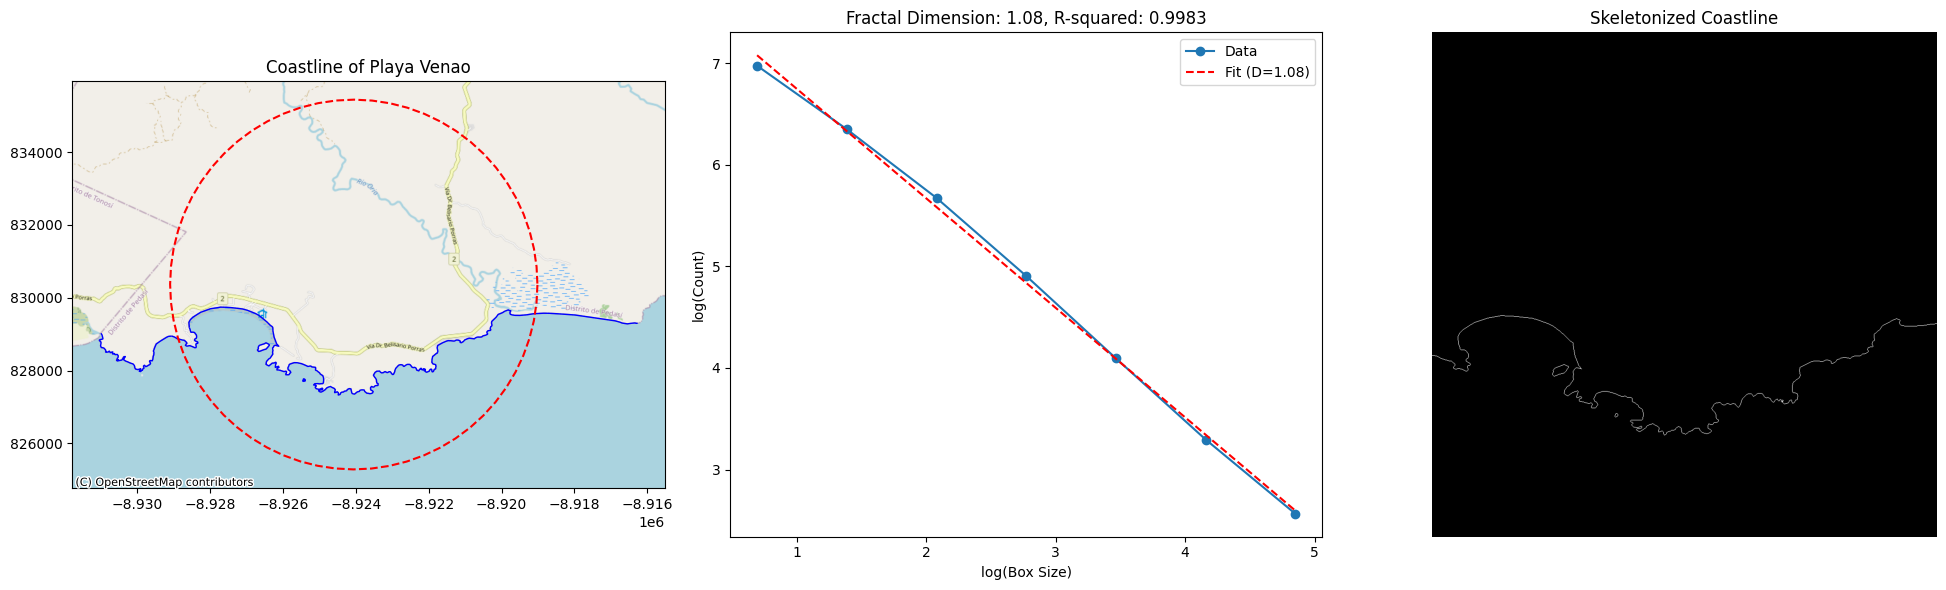

Fractal Dimension: 1.08, R-squared: 0.9983


In [24]:
# Main execution
coastline = download_coastline_data(LOCATION['lat'], LOCATION['lon'], BUFFER_DISTANCE)
coastline, bounds = preprocess_data(coastline, LOCATION['lat'], LOCATION['lon'], BUFFER_DISTANCE, UTM_CRS)
coastline_raster = rasterize_coastline(coastline, bounds, PIXEL_SIZE)
box_sizes, counts, fractal_dimension, r_value, coastline_skeleton = perform_fractal_analysis(coastline_raster)

visualize_results(coastline, bounds, box_sizes, counts, fractal_dimension, r_value, coastline_skeleton)

print(f"Fractal Dimension: {fractal_dimension:.2f}, R-squared: {r_value**2:.4f}")

   scale  fractal_dimension  r_squared
0      1           1.062508   0.996317
1      5           1.065281   0.997746
2     10           1.077599   0.998281
3     50           1.100637   0.996668
4    100           1.061307   0.995373


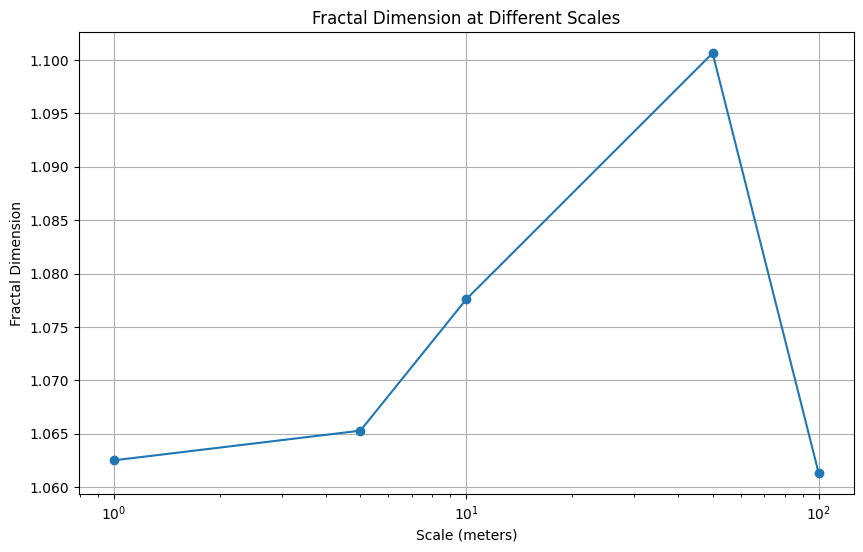

In [25]:
import pandas as pd

def analyze_at_multiple_scales(coastline, bounds, scales):
    results = []
    for scale in scales:
        raster = rasterize_coastline(coastline, bounds, scale)
        box_sizes, counts, fractal_dim, r_value, _ = perform_fractal_analysis(raster)
        results.append({
            'scale': scale,
            'fractal_dimension': fractal_dim,
            'r_squared': r_value**2
        })
    return pd.DataFrame(results)

# Define scales to analyze (in meters)
scales = [1, 5, 10, 50, 100]

# Perform multi-scale analysis
multi_scale_results = analyze_at_multiple_scales(coastline, bounds, scales)

# Display results
print(multi_scale_results)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(multi_scale_results['scale'], multi_scale_results['fractal_dimension'], 'o-')
plt.xscale('log')
plt.xlabel('Scale (meters)')
plt.ylabel('Fractal Dimension')
plt.title('Fractal Dimension at Different Scales')
plt.grid(True)
plt.show()

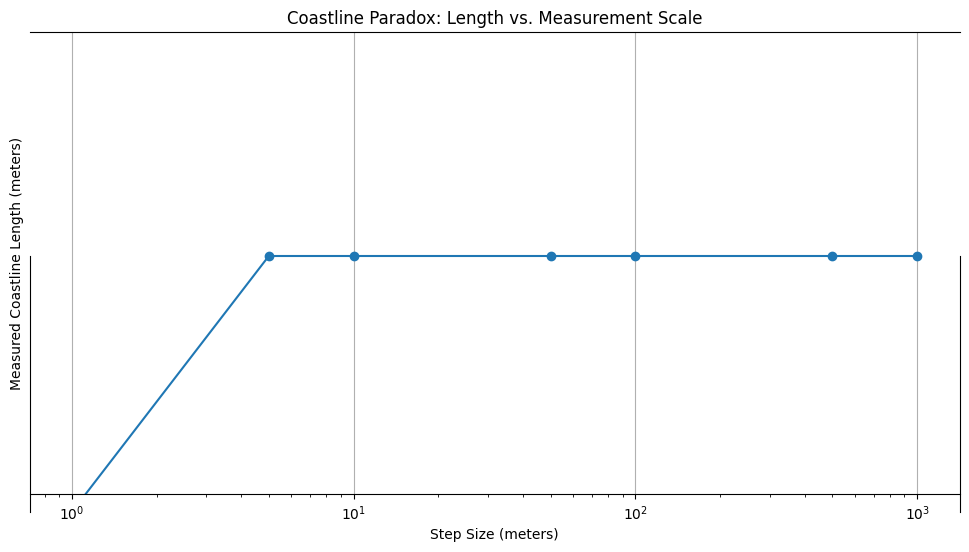

Fractal dimension calculated from length measurements: 1.000


In [26]:
from shapely.geometry import LineString

def measure_coastline_length(coastline, step_size):
    total_length = 0
    for line in coastline.geometry:
        points = list(line.coords)
        for i in range(len(points) - 1):
            segment = LineString([points[i], points[i+1]])
            segmented = segment.segmentize(step_size)
            total_length += segmented.length
    return total_length

step_sizes = [1, 5, 10, 50, 100, 500, 1000]  # in meters
lengths = [measure_coastline_length(coastline, step) for step in step_sizes]

plt.figure(figsize=(12, 6))
plt.plot(step_sizes, lengths, 'o-')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Step Size (meters)')
plt.ylabel('Measured Coastline Length (meters)')
plt.title('Coastline Paradox: Length vs. Measurement Scale')
plt.grid(True)
plt.show()

# Calculate and print the fractal dimension from this data
slope, _, _, _, _ = linregress(np.log(step_sizes), np.log(lengths))
fractal_dim = 1 - slope
print(f"Fractal dimension calculated from length measurements: {fractal_dim:.3f}")

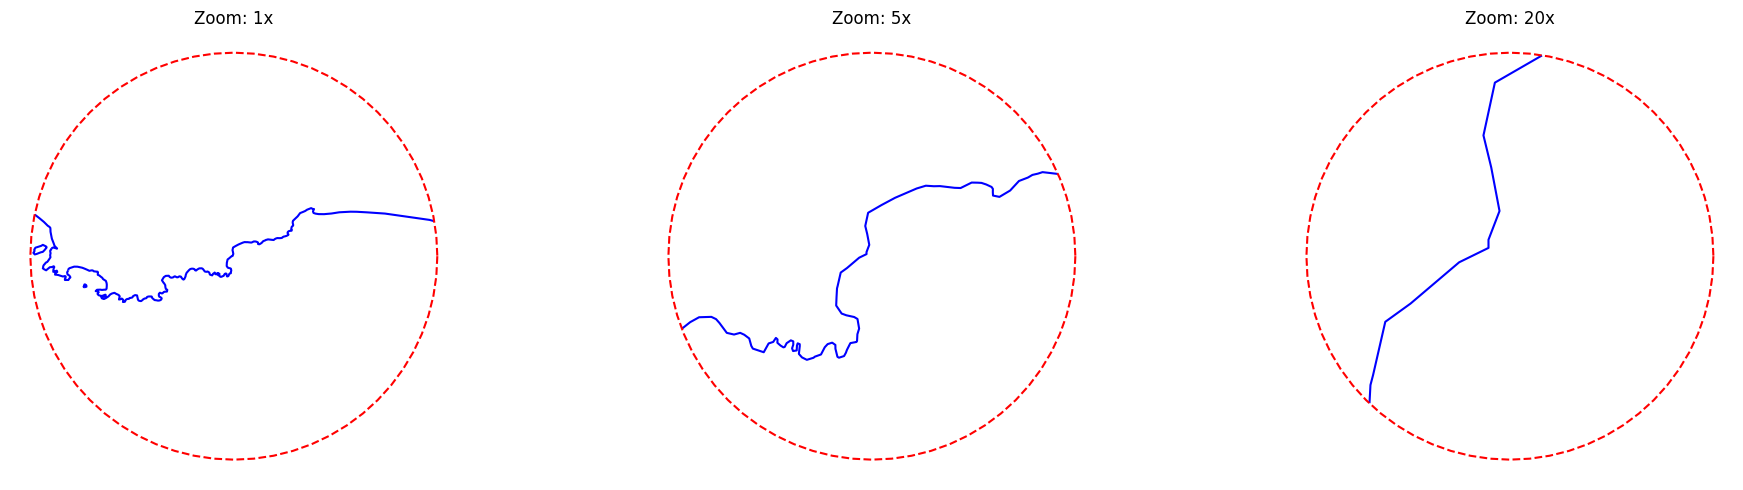

In [27]:
def plot_coastline_zoom(coastline, center_point, zoom_levels):
    fig, axes = plt.subplots(1, len(zoom_levels), figsize=(20, 5))
    for ax, zoom in zip(axes, zoom_levels):
        buffer_size = 5000 / zoom
        zoomed_area = gpd.GeoDataFrame(geometry=[center_point.buffer(buffer_size)], crs=coastline.crs)
        ax.set_aspect('equal')
        coastline.clip(zoomed_area.geometry.iloc[0]).plot(ax=ax, color='blue')
        zoomed_area.boundary.plot(ax=ax, color='red', linestyle='--')
        ax.set_title(f'Zoom: {zoom}x')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Choose a center point (you might need to adjust this based on your coastline)
center_point = coastline.geometry.centroid.iloc[0]

# Define zoom levels
zoom_levels = [1, 5, 20]

plot_coastline_zoom(coastline, center_point, zoom_levels)

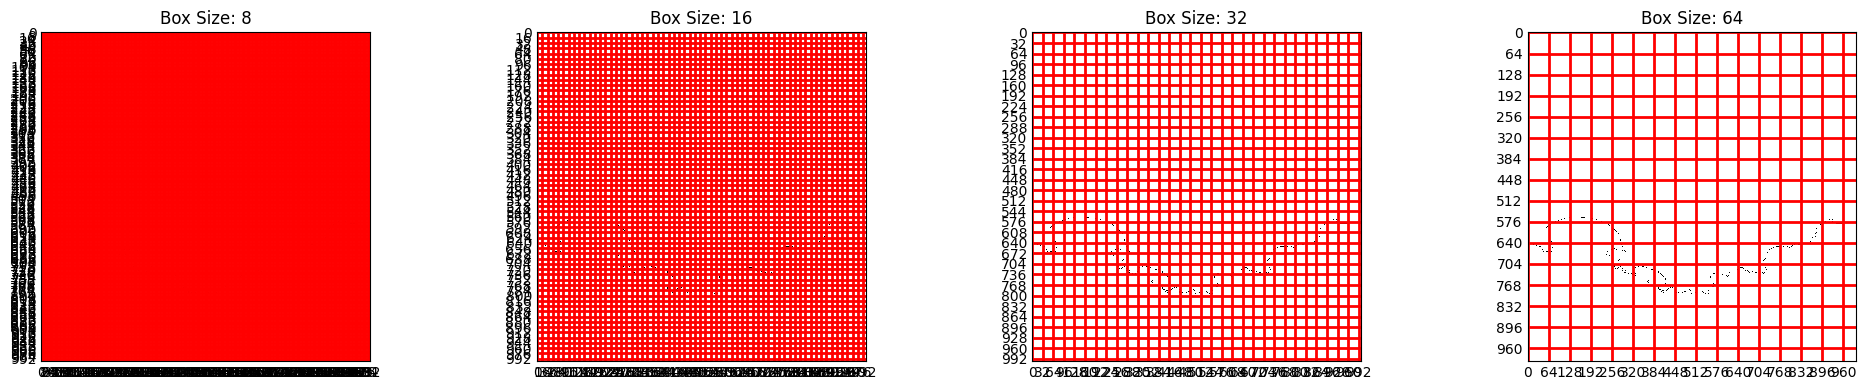

In [28]:
def visualize_box_counting(image, box_sizes):
    fig, axes = plt.subplots(1, len(box_sizes), figsize=(20, 4))
    for ax, size in zip(axes, box_sizes):
        ax.imshow(image, cmap='binary', interpolation='nearest')
        ax.set_title(f'Box Size: {size}')
        ax.set_xticks(np.arange(0, image.shape[1], size))
        ax.set_yticks(np.arange(0, image.shape[0], size))
        ax.grid(which='major', color='r', linestyle='-', linewidth=2)
        ax.tick_params(axis='both', which='both', length=0)
    plt.tight_layout()
    plt.show()

# Use a subset of box sizes for visualization
visualize_box_sizes = [8, 16, 32, 64]
visualize_box_counting(coastline_skeleton, visualize_box_sizes)

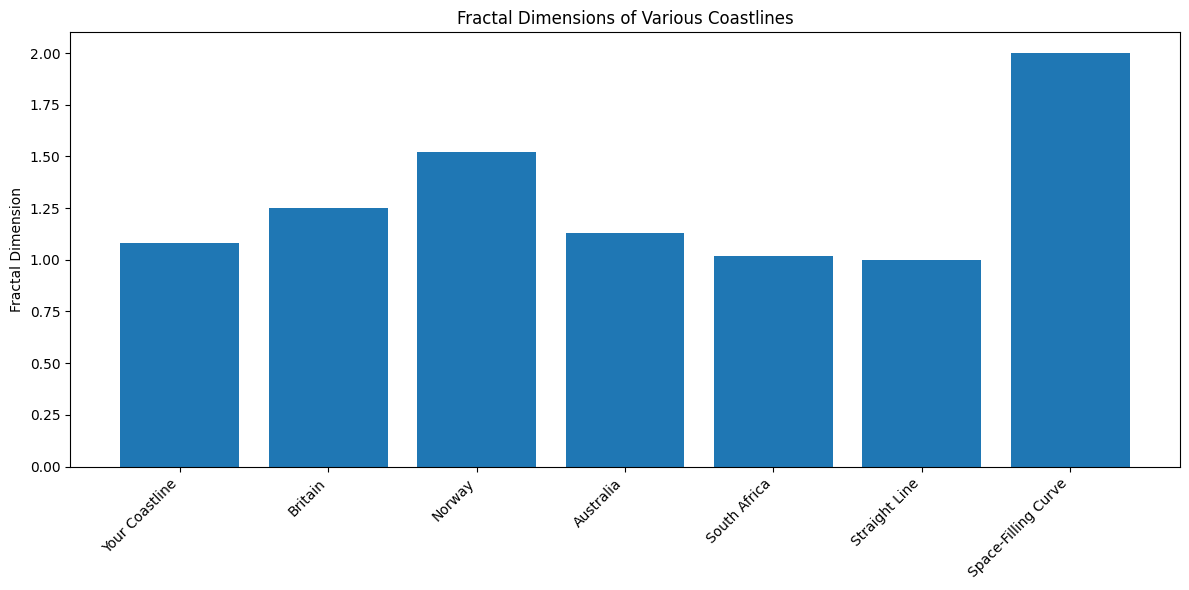

In [29]:
import matplotlib.pyplot as plt

coastlines = {
    'Your Coastline': 1.08,
    'Britain': 1.25,
    'Norway': 1.52,
    'Australia': 1.13,
    'South Africa': 1.02,
    'Straight Line': 1.00,
    'Space-Filling Curve': 2.00
}

plt.figure(figsize=(12, 6))
plt.bar(coastlines.keys(), coastlines.values())
plt.ylabel('Fractal Dimension')
plt.title('Fractal Dimensions of Various Coastlines')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [30]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
import osmnx as ox
from scipy.stats import linregress

# List of famous surf towns and some random coastal locations
surf_spots = [
    ("Pipeline, Hawaii", 21.6654, -158.0525, 9.5),
    ("Supertubes, Jeffrey's Bay, South Africa", -34.0497, 24.9307, 9.0),
    ("Uluwatu, Bali, Indonesia", -8.8128, 115.0890, 9.0),
    ("Teahupo'o, Tahiti", -17.8516, -149.2671, 9.5),
    ("Nazaré, Portugal", 39.6079, -9.0705, 8.5),
    ("Byron Bay, Australia", -28.6474, 153.6020, 8.0),
    ("Tofino, Canada", 49.1529, -125.9066, 7.5),
    ("Random Spot 1, Chile", -33.4489, -70.6693, 6.0),
    ("Random Spot 2, Japan", 35.6762, 139.6503, 5.5),
    ("Random Spot 3, New Zealand", -41.2865, 174.7762, 7.0)
]

# Create a DataFrame
df = pd.DataFrame(surf_spots, columns=['name', 'lat', 'lon', 'quality'])
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat), crs="EPSG:4326")

def get_coastline(lat, lon, distance=10000):
    """Get coastline data for a given location"""
    tags = {'natural': 'coastline'}
    try:
        coastline = ox.geometries_from_point((lat, lon), tags, dist=distance)
        coastline = coastline[coastline.geometry.type == 'LineString']
        return coastline.to_crs(epsg=3857)  # Convert to Web Mercator for consistent measurements
    except:
        print(f"Failed to fetch coastline data for {lat}, {lon}")
        return None

def calculate_fractal_dimension(coastline):
    """Calculate fractal dimension using box counting method"""
    if coastline is None or coastline.empty:
        return None
    
    bounds = coastline.total_bounds
    width = int((bounds[2] - bounds[0]) / 10)
    height = int((bounds[3] - bounds[1]) / 10)
    
    raster = rasterize(
        [(geom, 1) for geom in coastline.geometry],
        out_shape=(height, width),
        transform=rasterio.transform.from_bounds(*bounds, width=width, height=height),
        fill=0,
        dtype='uint8'
    )
    
    sizes = 2 ** np.arange(1, 8)
    counts = []
    for size in sizes:
        counted = block_reduce(raster, (size, size), func=np.any)
        counts.append(np.sum(counted))
    
    coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)
    return -coeffs[0]

# Calculate fractal dimensions
gdf['fractal_dim'] = gdf.apply(lambda row: calculate_fractal_dimension(get_coastline(row.lat, row.lon)), axis=1)

# Remove rows where fractal dimension couldn't be calculated
gdf = gdf.dropna(subset=['fractal_dim'])

# Plot results
plt.figure(figsize=(12, 8))
plt.scatter(gdf['fractal_dim'], gdf['quality'])
for i, row in gdf.iterrows():
    plt.annotate(row['name'], (row['fractal_dim'], row['quality']))

# Add trend line
slope, intercept, r_value, p_value, std_err = linregress(gdf['fractal_dim'], gdf['quality'])
x = np.array([gdf['fractal_dim'].min(), gdf['fractal_dim'].max()])
plt.plot(x, slope * x + intercept, color='red', linestyle='--', 
         label=f'Trend (R² = {r_value**2:.2f})')

plt.xlabel('Coastline Fractal Dimension')
plt.ylabel('Surf Spot Quality Rating')
plt.title('Relationship between Coastline Complexity and Surf Quality')
plt.legend()
plt.grid(True)
plt.show()

# Print results
print(gdf[['name', 'fractal_dim', 'quality']].sort_values('quality', ascending=False))

# Calculate correlation
correlation = gdf['fractal_dim'].corr(gdf['quality'])
print(f"\nCorrelation between fractal dimension and surf quality: {correlation:.2f}")

# Compare top spots to average
top_spots = gdf.sort_values('quality', ascending=False).head(5)
print(f"\nAverage fractal dimension of top 5 spots: {top_spots['fractal_dim'].mean():.2f}")
print(f"Overall average fractal dimension: {gdf['fractal_dim'].mean():.2f}")

/var/folders/ty/y5bm7r_s7cj1s6r4zbvt3ty80000gn/T/ipykernel_85837/2330485729.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  coastline = ox.geometries_from_point((lat, lon), tags, dist=distance)


NameError: name 'block_reduce' is not defined